# Binary Age Analysis of BNC2014 Corpus

Based on the paper excerpt, this notebook divides speakers in the British National Corpus 2014 (BNC2014) into two age groups:
1. **Youngsters**: Speakers aged 0-29 years
2. **Seniors**: Speakers aged 30+ years

We'll analyze linguistic differences between these two groups, examining:
- Lexical diversity and vocabulary size
- Word choice patterns
- Non-lexical vocalizations and discourse markers
- Turn-taking behaviors

## Import Required Libraries

In [1]:
# Standard library imports
import os
import re
from collections import Counter, defaultdict

# Data processing imports
import numpy as np
import pandas as pd
from lxml import etree

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Load the BNC2014 Data

First, we need to load the corpus data and metadata from the original BNC2014 assessment notebook. This assumes you have already run the data loading portions of the original notebook.

In [2]:
# Set the path to the dataset
path = 'Dataset'  # Change if needed
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Check if the directories exist
if not os.path.exists(dir_corpus) or not os.path.exists(dir_meta):
    print("Warning: Dataset directories not found. Please make sure the correct path is set.")
else:
    print(f"Corpus directory found at: {dir_corpus}")
    print(f"Metadata directory found at: {dir_meta}")

Corpus directory found at: Dataset\spoken\tagged
Metadata directory found at: Dataset\spoken\metadata


In [3]:
# Load speaker metadata
try:
    # Load field-name lookups
    fields_s = pd.read_csv(
        os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
        sep='\t', skiprows=1, index_col=0
    )
    
    # Load the speaker metadata (indexed by speaker_id)
    df_speakers_meta = pd.read_csv(
        os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
        sep='\t', names=fields_s['XML tag'], index_col=0
    )
    
    print(f"Successfully loaded metadata for {len(df_speakers_meta)} speakers")
    print("\nSample of speaker metadata:")
    print(df_speakers_meta.head())
    
except Exception as e:
    print(f"Error loading speaker metadata: {e}")

Successfully loaded metadata for 671 speakers

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midl

In [4]:
# Load tagged corpus data
import lxml.etree as ET

tagged_rows = []
try:
    # Process only a subset of files for demonstration (can be increased)
    for file_count, fname in enumerate(os.listdir(dir_corpus)[:10]):  # Limit to 10 files for quick demo
        fpath = os.path.join(dir_corpus, fname)
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            utt_id = u.get('n')
            spk = u.get('who')
            for w in u.findall('w'):
                tagged_rows.append({
                    'text_id': text_id,
                    'utterance_id': utt_id,
                    'speaker_id': spk,
                    'word': w.text,
                    'lemma': w.get('lemma'),
                    'pos': w.get('pos'),
                    'class': w.get('class'),
                    'usas': w.get('usas'),
                })
                
        if file_count % 2 == 0:
            print(f"Processed {file_count+1} files...")

    df_tagged = pd.DataFrame(tagged_rows)
    print(f"\nSuccessfully loaded {len(df_tagged)} words from {file_count+1} files")
    print("\nSample of tagged data:")
    print(df_tagged.head())
    
except Exception as e:
    print(f"Error loading corpus data: {e}")

Processed 1 files...
Processed 3 files...
Processed 5 files...
Processed 7 files...
Processed 9 files...

Successfully loaded 104355 words from 10 files

Sample of tagged data:
  text_id utterance_id speaker_id   word lemma   pos  class  usas
0    S23A            1      S0094  words  word   NN2  SUBST    Q3
1    S23A            2      S0095     it    it  PPH1   PRON    Z8
2    S23A            2      S0095     's    be   VBZ   VERB    A3
3    S23A            2      S0095      a     a   AT1    ART    Z5
4    S23A            2      S0095  games  game   NN2  SUBST  K5:1


In [5]:
# Load untagged corpus data for utterance-level analysis
untagged_rows = []
try:
    dir_untagged = os.path.join(path, 'spoken', 'untagged')
    
    # Process only a subset of files for demonstration
    for file_count, fname in enumerate(os.listdir(dir_untagged)[:10]):  # Limit to 10 files
        fpath = os.path.join(dir_untagged, fname)
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            raw_text = ''.join(u.itertext()).strip()
            untagged_rows.append({
                'text_id': text_id,
                'utterance_id': u.get('n') or u.get('uID'),
                'speaker_id': u.get('who'),
                'raw_text': raw_text,
                'utt_length': len(raw_text.split())
            })
    
    df_untagged = pd.DataFrame(untagged_rows)
    print(f"\nSuccessfully loaded {len(df_untagged)} utterances from {file_count+1} files")
    print("\nSample of untagged data:")
    print(df_untagged.head())
    
except Exception as e:
    print(f"Error loading untagged corpus data: {e}")


Successfully loaded 13812 utterances from 10 files

Sample of untagged data:
  text_id utterance_id speaker_id  \
0    S23A            1      S0094   
1    S23A            2      S0095   
2    S23A            3      S0032   
3    S23A            4      S0095   
4    S23A            5      S0032   

                                            raw_text  utt_length  
0                                              words           1  
1     it's a games word? like a computer games word?           9  
2                                          yeah yeah           2  
3                                  oh oh that's nice           4  
4  I it's something I have really heard z-buffer ...          13  


## Create Speaker-Level DataFrame

Next, we'll create a speaker-level dataframe with aggregated metrics.

In [6]:
def create_speaker_dataframe(df_untagged, df_speakers_meta):
    """
    Create a comprehensive speaker-level dataframe with aggregated metrics from utterance data.
    
    Parameters:
    -----------
    df_untagged : pandas.DataFrame
        DataFrame containing utterance-level data with speaker_id, text_id, etc.
    df_speakers_meta : pandas.DataFrame
        DataFrame containing speaker metadata indexed by speaker_id
    
    Returns:
    --------
    pandas.DataFrame
        A speaker-level dataframe with aggregated metrics and metadata
    """
    # Group utterances by speaker_id and aggregate data
    speaker_df = df_untagged.groupby('speaker_id').agg({
        'text_id': lambda x: list(set(x)),  # List of unique text IDs for each speaker
        'utterance_id': 'count',            # Count of utterances per speaker
        'raw_text': lambda x: ' '.join(x),  # Join all utterances into one text
        'utt_length': ['sum', 'mean']       # Total and average utterance length
    })
    
    # Flatten the multi-level column names
    speaker_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in speaker_df.columns.values]
    
    # Rename columns for clarity
    speaker_df = speaker_df.rename(columns={
        'text_id_<lambda>': 'text_ids',
        'utterance_id_count': 'num_utterances',
        'raw_text_<lambda>': 'all_utterances',
        'utt_length_sum': 'total_words',
        'utt_length_mean': 'avg_utt_length'
    })
    
    # Add number of texts per speaker
    speaker_df['num_texts'] = speaker_df['text_ids'].apply(len)
    
    # Add total character length 
    speaker_df['total_chars'] = speaker_df['all_utterances'].apply(len)
    
    # Calculate vocabulary size (unique words)
    speaker_df['vocab_size'] = speaker_df['all_utterances'].apply(
        lambda x: len(set(x.lower().split()))
    )
    
    # Calculate lexical diversity (unique words / total words)
    # Add a small epsilon to prevent division by zero
    speaker_df['lexical_diversity'] = speaker_df['vocab_size'] / (speaker_df['total_words'] + 1e-10)
    
    # Merge with speaker metadata
    if df_speakers_meta is not None:
        speaker_df = speaker_df.join(df_speakers_meta, how='left')
    
    return speaker_df

# Create the speaker-level DataFrame
try:
    speaker_df = create_speaker_dataframe(df_untagged, df_speakers_meta)
    print(f"Created speaker-level dataframe with {len(speaker_df)} unique speakers")
    print("\nSample of speaker dataframe:")
    print(speaker_df.head())
except Exception as e:
    print(f"Error creating speaker dataframe: {e}")

Created speaker-level dataframe with 32 unique speakers

Sample of speaker dataframe:
           text_ids  num_utterances  \
speaker_id                            
S0012        [S26N]             361   
S0013        [S26N]             305   
S0021        [S23A]            1128   
S0024        [S27D]             399   
S0032        [S23A]             964   

                                               all_utterances  total_words  \
speaker_id                                                                   
S0012       oh right yeah yeah he put it on the system did...         2652   
S0013       mm mm I'll just and get mine it's all cold no ...         1995   
S0021       itadakimasu thank you for cooking mm  rice is ...         7473   
S0024       well I sent I sent a text  I put um hang on le...         3141   
S0032       yeah yeah I it's something I have really heard...         6242   

            avg_utt_length  num_texts  total_chars  vocab_size  \
speaker_id                 

## Create Binary Age Classification

Following the paper's approach, we'll divide speakers into two age categories:
1. **Youngsters**: Speakers aged 0-29 years
2. **Seniors**: Speakers aged 30+ years

In [7]:
# Function to map agerange to binary age group
def map_to_binary_age_group(age_range):
    """
    Map BNC age ranges to binary classification:
    - Youngsters: 0-29 years
    - Seniors: 30+ years
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC2014 metadata
        
    Returns:
    --------
    str
        'Youngsters' or 'Seniors'
    """
    if pd.isna(age_range):
        return np.nan
    
    try:
        # Handle different format separators
        if '_' in str(age_range):
            ages = str(age_range).split('_')
        elif '-' in str(age_range):
            ages = str(age_range).split('-')
        else:
            return np.nan
            
        # Extract upper bound of age range
        upper = int(ages[1])
        
        # Apply binary classification
        if upper <= 29:
            return "Youngsters"
        else:
            return "Seniors"
            
    except Exception as e:
        return np.nan

# Display current age range distribution in the data
print("Current age range distribution in the data:")
print(speaker_df['agerange'].value_counts())

# Apply the binary classification
speaker_df['binary_age_group'] = speaker_df['agerange'].apply(map_to_binary_age_group)

# Display the resulting binary age group distribution
binary_age_counts = speaker_df['binary_age_group'].value_counts()
print("\nBinary age group distribution:")
print(binary_age_counts)
print(f"Percentage: {binary_age_counts / binary_age_counts.sum() * 100}")

# Create separate dataframes for each group
youngsters_df = speaker_df[speaker_df['binary_age_group'] == 'Youngsters'].copy()
seniors_df = speaker_df[speaker_df['binary_age_group'] == 'Seniors'].copy()

print(f"\nYoungsters dataset: {len(youngsters_df)} speakers")
print(f"Seniors dataset: {len(seniors_df)} speakers")

Current age range distribution in the data:
agerange
30_39      7
40_49      5
50_59      4
11_18      4
70_79      3
Unknown    3
60_69      2
19_29      2
0_10       2
Name: count, dtype: int64

Binary age group distribution:
binary_age_group
Seniors       21
Youngsters     8
Name: count, dtype: int64
Percentage: binary_age_group
Seniors       72.413793
Youngsters    27.586207
Name: count, dtype: float64

Youngsters dataset: 8 speakers
Seniors dataset: 21 speakers


## Compare Linguistic Features Between Age Groups

Now let's visualize key linguistic differences between Youngsters and Seniors.

C:\Users\jubal\AppData\Local\Temp\ipykernel_55756\98908766.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='binary_age_group', y='lexical_diversity', data=speaker_df,
C:\Users\jubal\AppData\Local\Temp\ipykernel_55756\98908766.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='binary_age_group', y='avg_utt_length', data=speaker_df,
C:\Users\jubal\AppData\Local\Temp\ipykernel_55756\98908766.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='binary_age_group', y='vocab_size', data=speaker_df,


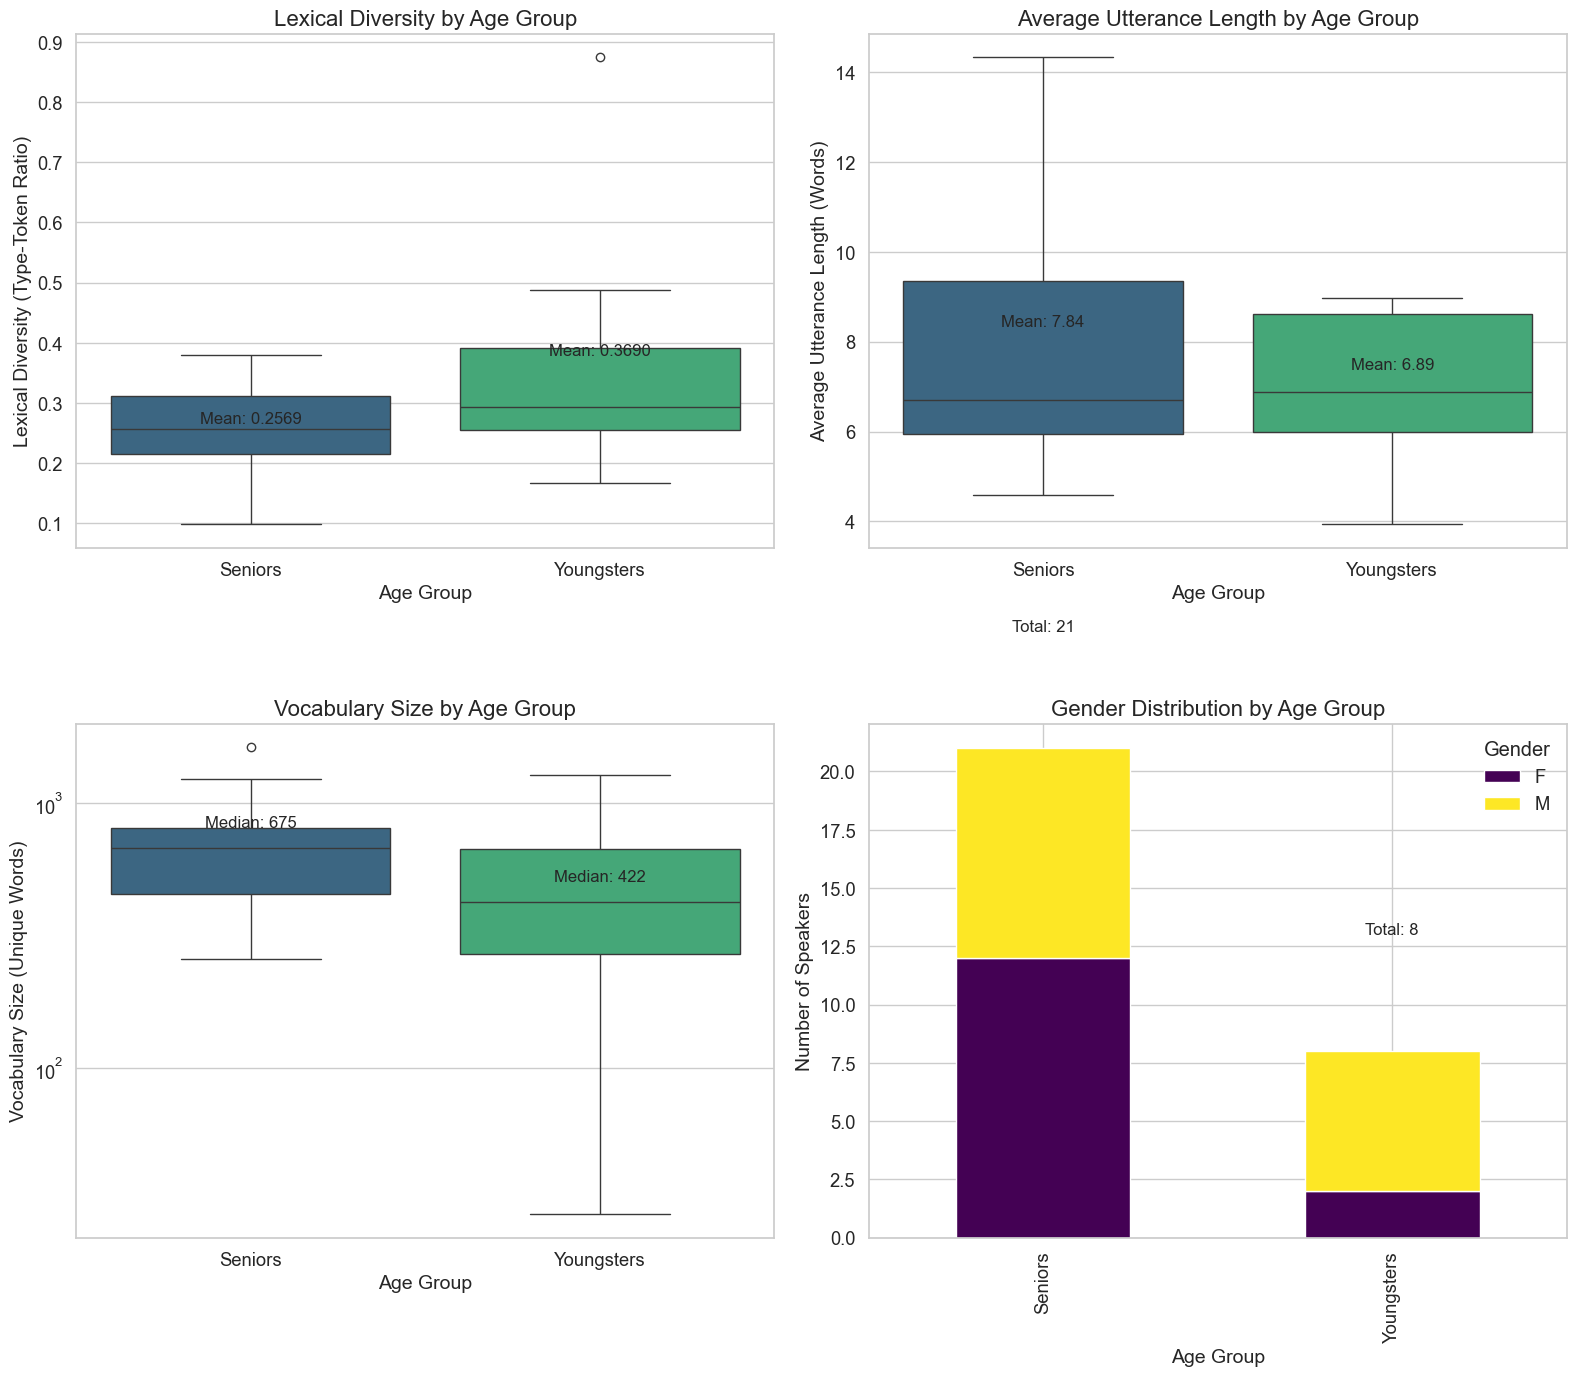

In [8]:
# Visualize the differences in linguistic features between the two age groups
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Lexical diversity comparison
sns.boxplot(x='binary_age_group', y='lexical_diversity', data=speaker_df, 
            palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Lexical Diversity by Age Group', fontsize=16)
axes[0, 0].set_xlabel('Age Group', fontsize=14)
axes[0, 0].set_ylabel('Lexical Diversity (Type-Token Ratio)', fontsize=14)

# Add statistical annotation
mean_lex_diversity = speaker_df.groupby('binary_age_group')['lexical_diversity'].mean()
for i, age_group in enumerate(mean_lex_diversity.index):
    axes[0, 0].text(i, mean_lex_diversity[age_group] + 0.01, 
                  f'Mean: {mean_lex_diversity[age_group]:.4f}', 
                  ha='center', fontsize=12)

# 2. Average utterance length comparison
sns.boxplot(x='binary_age_group', y='avg_utt_length', data=speaker_df, 
            palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Average Utterance Length by Age Group', fontsize=16)
axes[0, 1].set_xlabel('Age Group', fontsize=14)
axes[0, 1].set_ylabel('Average Utterance Length (Words)', fontsize=14)

# Add statistical annotation
mean_utt_length = speaker_df.groupby('binary_age_group')['avg_utt_length'].mean()
for i, age_group in enumerate(mean_utt_length.index):
    axes[0, 1].text(i, mean_utt_length[age_group] + 0.5, 
                  f'Mean: {mean_utt_length[age_group]:.2f}', 
                  ha='center', fontsize=12)

# 3. Total vocabulary size comparison
sns.boxplot(x='binary_age_group', y='vocab_size', data=speaker_df, 
            palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Vocabulary Size by Age Group', fontsize=16)
axes[1, 0].set_xlabel('Age Group', fontsize=14)
axes[1, 0].set_ylabel('Vocabulary Size (Unique Words)', fontsize=14)
axes[1, 0].set_yscale('log')

# Add statistical annotation
median_vocab_size = speaker_df.groupby('binary_age_group')['vocab_size'].median()
for i, age_group in enumerate(median_vocab_size.index):
    axes[1, 0].text(i, median_vocab_size[age_group] * 1.2, 
                  f'Median: {median_vocab_size[age_group]:.0f}', 
                  ha='center', fontsize=12)

# 4. Gender distribution within age groups
if 'gender' in speaker_df.columns:
    gender_age_counts = pd.crosstab(speaker_df['binary_age_group'], speaker_df['gender'])
    gender_age_counts.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='viridis')
    axes[1, 1].set_title('Gender Distribution by Age Group', fontsize=16)
    axes[1, 1].set_xlabel('Age Group', fontsize=14)
    axes[1, 1].set_ylabel('Number of Speakers', fontsize=14)
    axes[1, 1].legend(title='Gender')
    
    # Add count labels
    for i, age_group in enumerate(gender_age_counts.index):
        total = gender_age_counts.loc[age_group].sum()
        axes[1, 1].text(i, total + 5, f'Total: {total}', ha='center', fontsize=12)
else:
    axes[1, 1].text(0.5, 0.5, "Gender data not available", 
                    ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Gender Distribution by Age Group', fontsize=16)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('binary_age_group_comparisons.png', dpi=300)
plt.show()

## Analysis of Non-lexical Vocalizations

As described in the paper excerpt, we'll analyze non-lexical vocalizations and turn-taking features that differ between age groups.

Mean frequencies of non-lexical vocalizations per 1000 words:
                  positive_response_per_1k  turn_stalling_per_1k  \
binary_age_group                                                   
Seniors                          13.382879                   0.0   
Youngsters                        3.090267                   0.0   

                  turn_management_per_1k  repair_initiator_per_1k  \
binary_age_group                                                    
Seniors                        12.145402                      0.0   
Youngsters                     10.342349                      0.0   

                  change_of_state_per_1k  
binary_age_group                          
Seniors                         8.596686  
Youngsters                      8.880089  


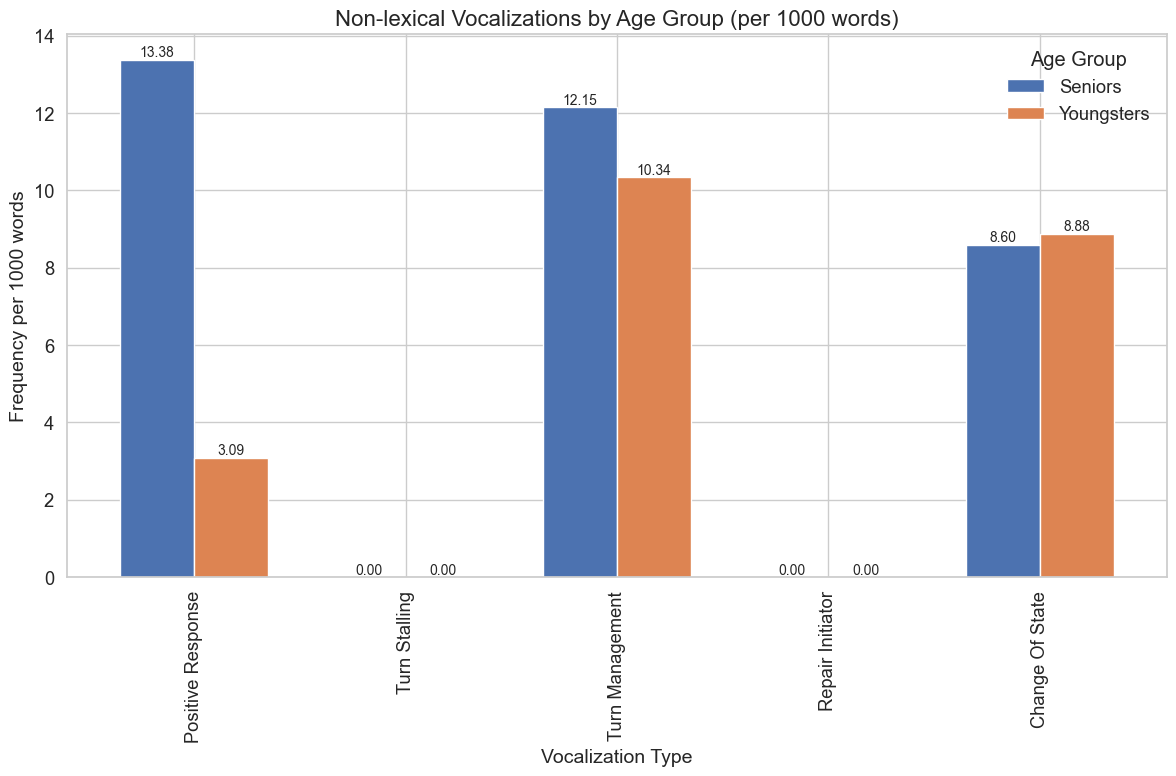

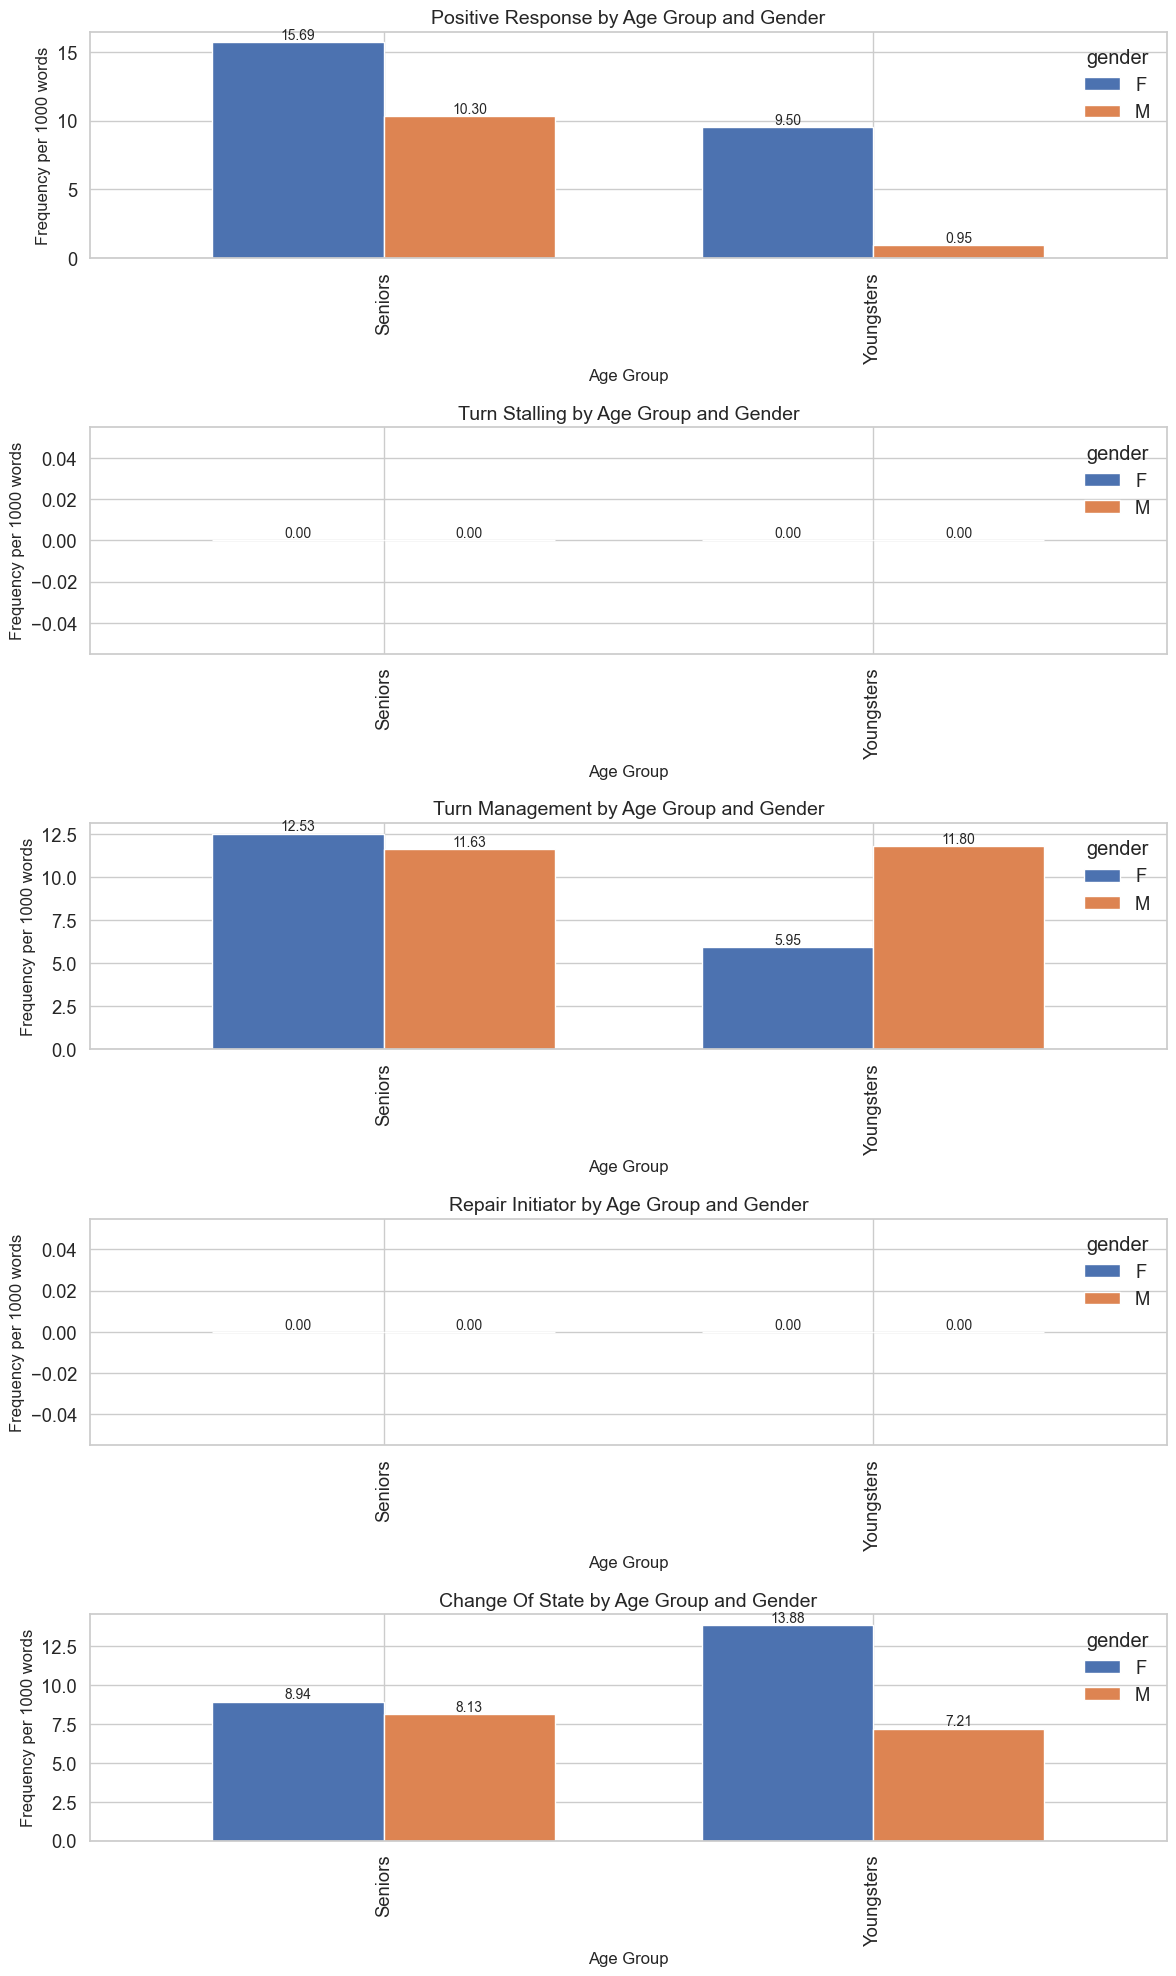

In [9]:
# Function to identify non-lexical vocalizations in text
def analyze_vocalizations(text_series):
    """
    Analyze a series of texts for various non-lexical vocalizations.
    
    Parameters:
    -----------
    text_series : pandas.Series
        Series containing utterance texts
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with counts of different vocalization types
    """
    # Define regular expressions for different vocalization types
    vocalization_patterns = {
        'positive_response': r'\b(mm|mhm|uhu|uhuh|aha|uh huh)\b',
        'turn_stalling': r'\b(hmm|hmmm)\b',
        'turn_management': r'\b(um|er|erm)\b',
        'repair_initiator': r'\bhm\?\b',
        'change_of_state': r'\boh\b'
    }
    
    # Count occurrences for each speaker
    results = {}
    
    for pattern_name, regex in vocalization_patterns.items():
        # Count occurrences in each text
        results[pattern_name] = text_series.str.count(regex, flags=re.IGNORECASE).fillna(0)
    
    # Create DataFrame with results
    return pd.DataFrame(results)

try:
    # Apply analysis to the utterance texts for each speaker
    vocalization_df = analyze_vocalizations(speaker_df['all_utterances'])
    
    # Add binary age group column
    vocalization_df['binary_age_group'] = speaker_df['binary_age_group'] 
    if 'gender' in speaker_df.columns:
        vocalization_df['gender'] = speaker_df['gender']
    vocalization_df['total_words'] = speaker_df['total_words']
    
    # Calculate normalized frequencies (per 1000 words)
    for col in ['positive_response', 'turn_stalling', 'turn_management', 'repair_initiator', 'change_of_state']:
        vocalization_df[f'{col}_per_1k'] = vocalization_df[col] / vocalization_df['total_words'] * 1000
    
    # Aggregate results by age group
    agg_by_age = vocalization_df.groupby('binary_age_group').agg({
        'positive_response_per_1k': 'mean',
        'turn_stalling_per_1k': 'mean',
        'turn_management_per_1k': 'mean',
        'repair_initiator_per_1k': 'mean',
        'change_of_state_per_1k': 'mean'
    })
    
    print("Mean frequencies of non-lexical vocalizations per 1000 words:")
    print(agg_by_age)
    
    # Create comparative visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Transpose to get features as x-axis
    agg_by_age_t = agg_by_age.T
    
    # Plot
    agg_by_age_t.plot(kind='bar', ax=ax, width=0.7)
    ax.set_title('Non-lexical Vocalizations by Age Group (per 1000 words)', fontsize=16)
    ax.set_ylabel('Frequency per 1000 words', fontsize=14)
    ax.set_xlabel('Vocalization Type', fontsize=14)
    ax.set_xticklabels([x.replace('_per_1k', '').replace('_', ' ').title() for x in agg_by_age_t.index])
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=10)
    
    plt.legend(title='Age Group')
    plt.tight_layout()
    plt.savefig('vocalization_by_binary_age.png', dpi=300)
    plt.show()
    
    # Also analyze by gender if available
    if 'gender' in vocalization_df.columns:
        # Filter to include only M/F genders for clarity
        agg_by_age_gender = vocalization_df[vocalization_df['gender'].isin(['M', 'F'])].groupby(['binary_age_group', 'gender']).agg({
            'positive_response_per_1k': 'mean',
            'turn_stalling_per_1k': 'mean', 
            'turn_management_per_1k': 'mean',
            'repair_initiator_per_1k': 'mean',
            'change_of_state_per_1k': 'mean'
        }).reset_index()
        
        # Create a figure for each vocalization type
        vocalization_types = [col for col in agg_by_age_gender.columns if col.endswith('_per_1k')]
        
        fig, axes = plt.subplots(len(vocalization_types), 1, figsize=(12, 4*len(vocalization_types)))
        
        for i, v_type in enumerate(vocalization_types):
            # Create temporary DataFrame for plotting
            plot_df = agg_by_age_gender.pivot(index='binary_age_group', columns='gender', values=v_type)
            plot_df.plot(kind='bar', ax=axes[i] if len(vocalization_types) > 1 else axes, width=0.7)
            
            # Set titles and labels
            current_ax = axes[i] if len(vocalization_types) > 1 else axes
            current_ax.set_title(f'{v_type.replace("_per_1k", "").replace("_", " ").title()} by Age Group and Gender', fontsize=14)
            current_ax.set_ylabel('Frequency per 1000 words', fontsize=12)
            current_ax.set_xlabel('Age Group', fontsize=12)
            
            # Add value labels
            for container in current_ax.containers:
                current_ax.bar_label(container, fmt='%.2f', fontsize=10)
        
        plt.tight_layout()
        plt.savefig('vocalization_by_age_and_gender.png', dpi=300)
        plt.show()
        
except Exception as e:
    print(f"Error analyzing vocalizations: {e}")

## Characteristic Words Analysis

Following the approach in the paper, we'll identify words that are distinctively associated with each age group.


Top characteristic words for Youngsters:
--------------------------------------------------
Word             Specificity    Count   Per 1000
--------------------------------------------------
hummus                 23.38       14       1.09
bum                    23.04       11       0.86
wichi                  22.58        8       0.63
malaysia               22.58        8       0.63
horns                  22.38        7       0.55
trees                  22.38        7       0.55
nba                    22.38        7       0.55
honey                  22.38        7       0.55
mr                     22.38        7       0.55
dick                   22.38        7       0.55
deadpool               22.38        7       0.55
player                 22.16        6       0.47
bu                     22.16        6       0.47
buff                   22.16        6       0.47
prawn                  22.16        6       0.47
hates                  22.16        6       0.47
dud                    

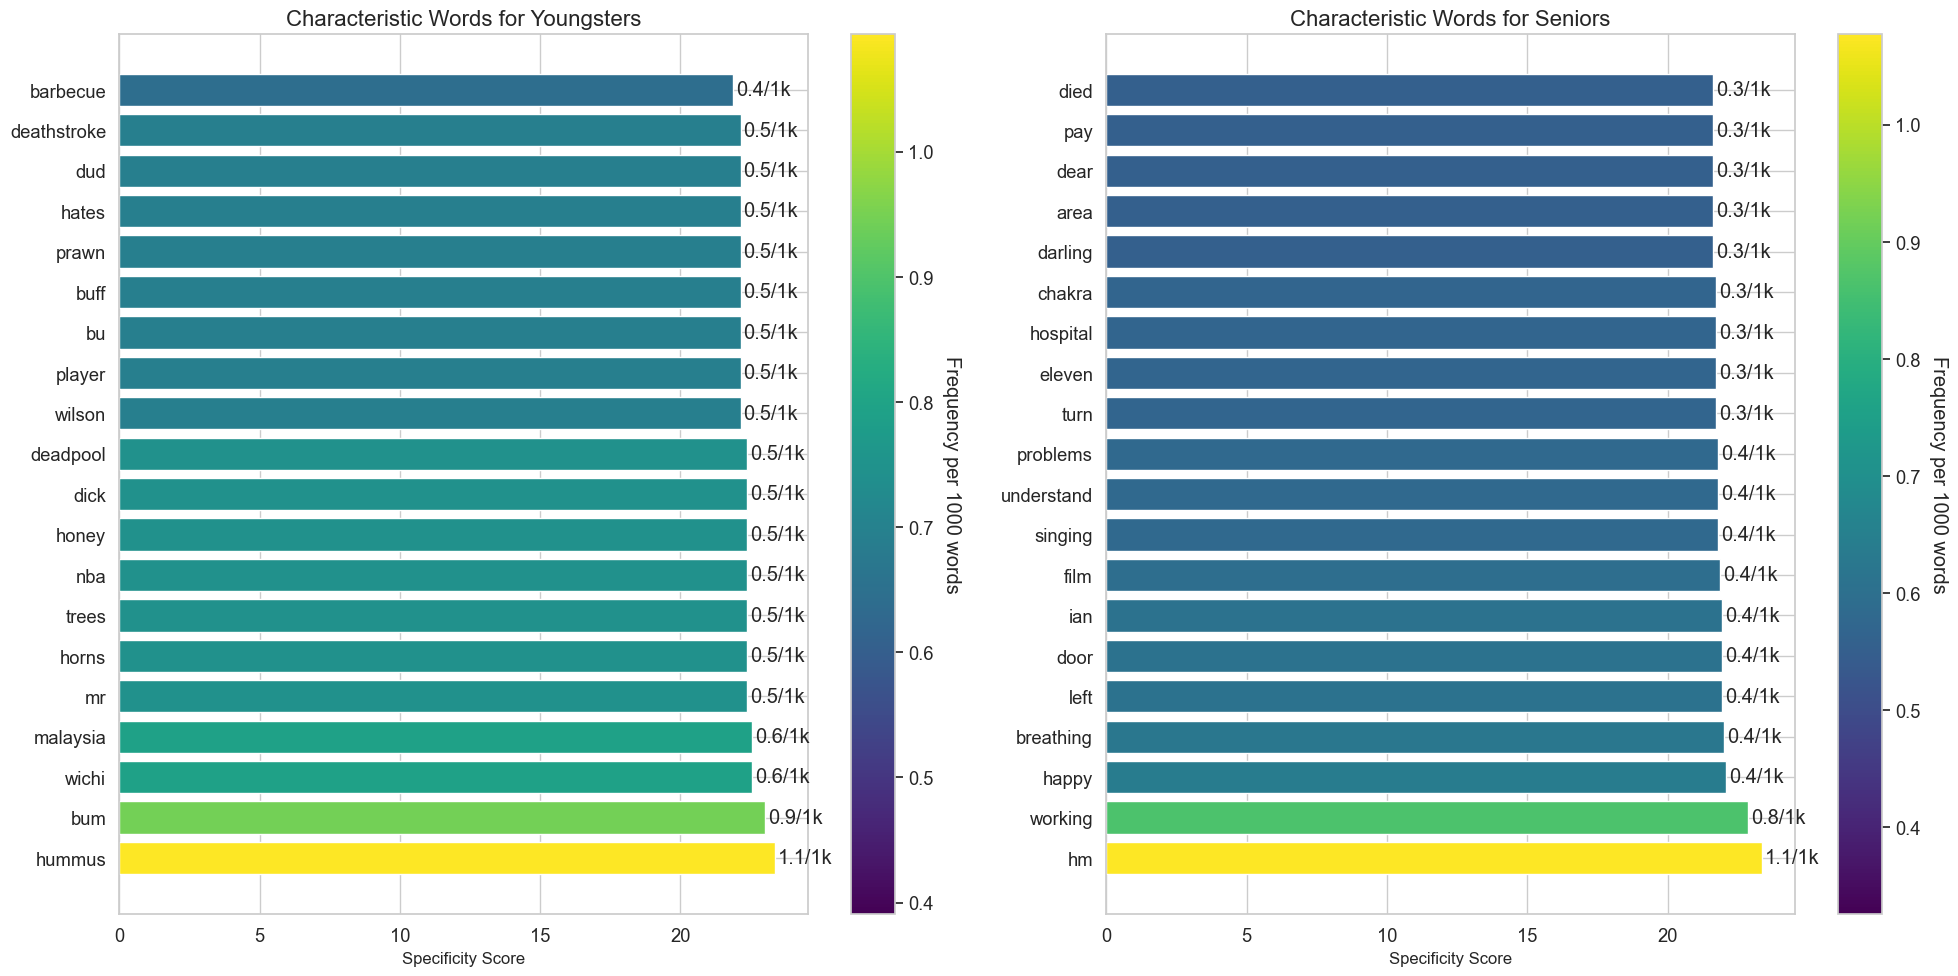

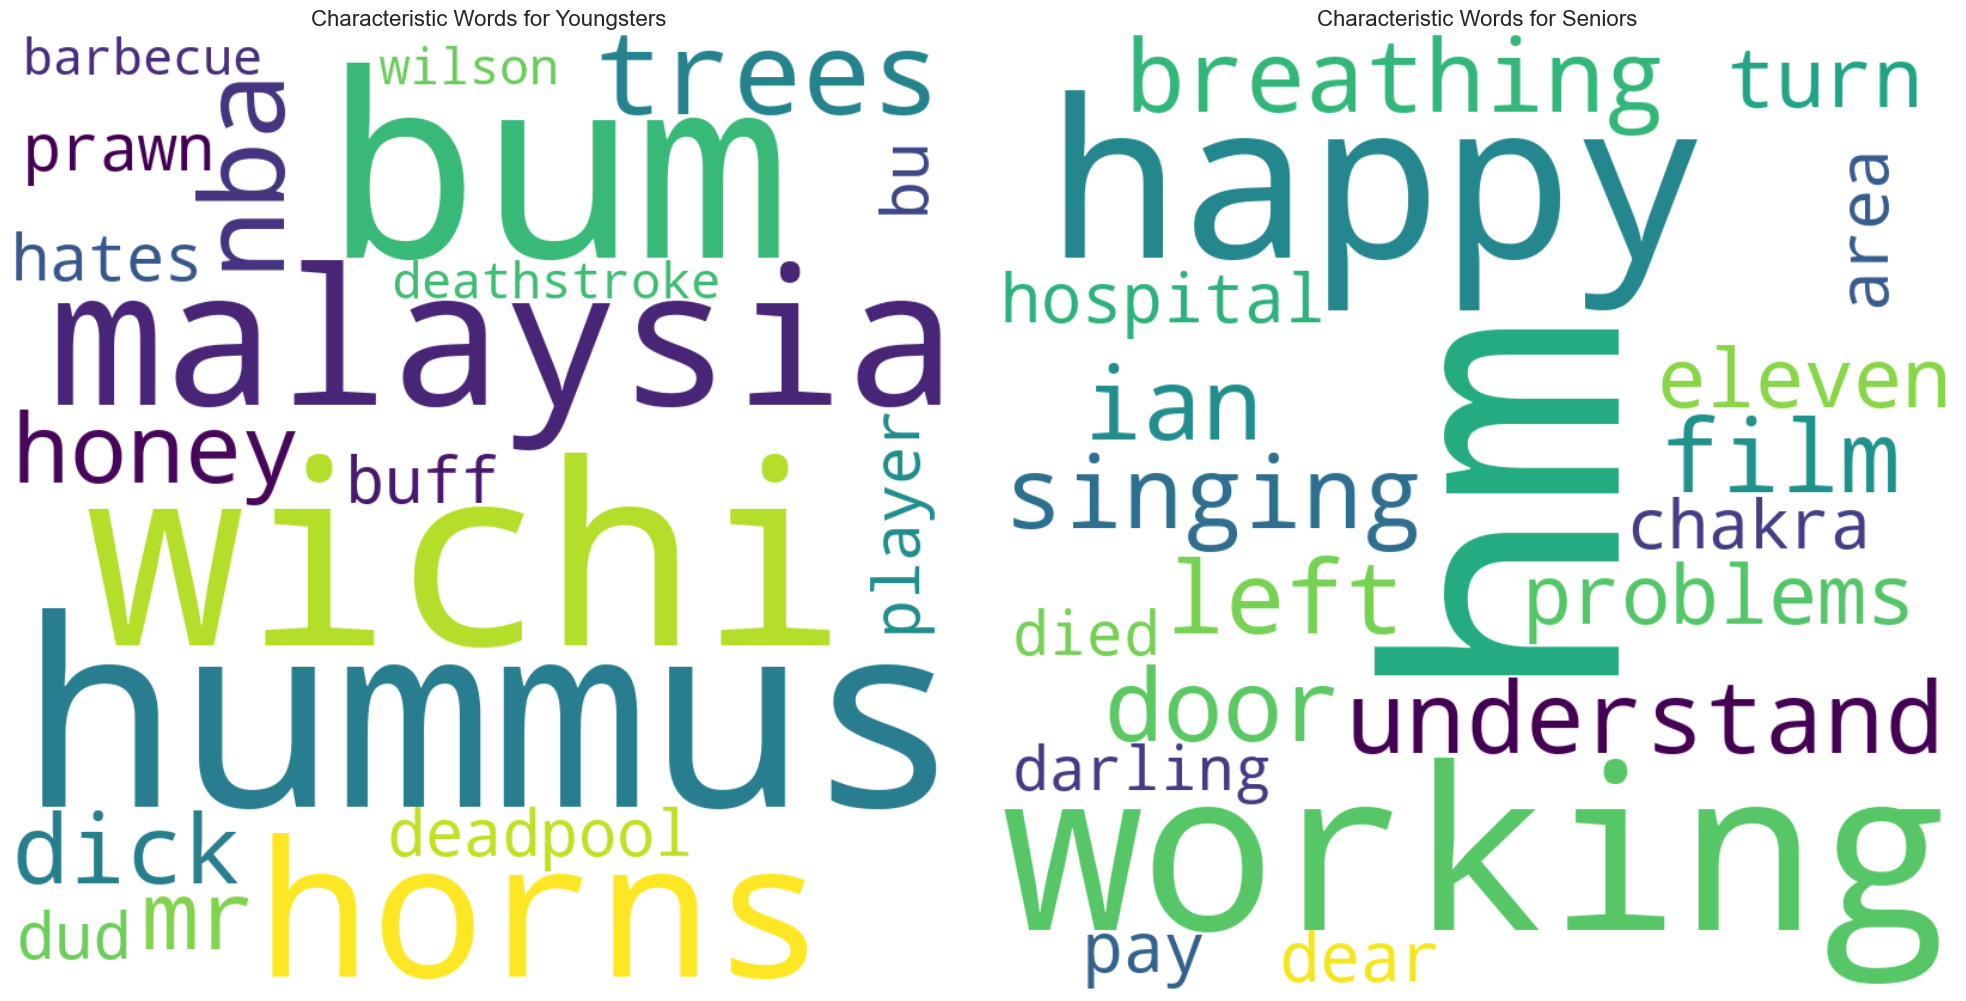

In [10]:
def get_characteristic_words(df_tagged, speaker_ids_by_group, min_count=5, top_n=20):
    """
    Find characteristic words for each group using a simple frequency analysis.
    
    Parameters:
    -----------
    df_tagged : pandas.DataFrame
        DataFrame containing the tagged words with speaker_id
    speaker_ids_by_group : dict
        Dictionary mapping group names to lists of speaker IDs
    min_count : int
        Minimum count for a word to be considered
    top_n : int
        Number of top words to return for each group
        
    Returns:
    --------
    dict
        Dictionary containing characteristic words for each group
    """
    # Define stopwords to exclude
    stopwords = set([
        'the', 'and', 'to', 'a', 'of', 'in', 'i', 'it', 'that', 'you', 'is', 
        'for', 'on', 'have', 'with', 'be', 'this', 'are', 'was', 'but', 'not', 
        'they', 'so', 'we', 'what', 'um', 'er', 'erm', 'eh', 'mm'
    ])
    
    # Collect words by group
    word_counts_by_group = {}
    total_words_by_group = {}
    
    for group, speaker_ids in speaker_ids_by_group.items():
        # Get words for all speakers in this group
        group_words = df_tagged[df_tagged['speaker_id'].isin(speaker_ids)]['word']
        
        # Clean and normalize words
        clean_words = []
        for word in group_words:
            if pd.notna(word):
                # Convert to lowercase and remove punctuation
                clean_word = re.sub(r'[^\w\s]', '', str(word).lower())
                if clean_word and clean_word not in stopwords and len(clean_word) > 1:
                    clean_words.append(clean_word)
        
        # Count words
        word_counts = Counter(clean_words)
        word_counts_by_group[group] = word_counts
        total_words_by_group[group] = len(clean_words)
    
    # Calculate scaled frequency for each word in each group
    characteristic_words = {}
    
    for group in speaker_ids_by_group.keys():
        scores = {}
        
        for word, count in word_counts_by_group[group].items():
            if count < min_count:
                continue
                
            # Calculate frequency in this group
            freq_in_group = count / total_words_by_group[group]
            
            # Calculate frequency in other groups
            other_groups = [g for g in speaker_ids_by_group.keys() if g != group]
            
            other_count = 0
            other_total = 0
            for other_group in other_groups:
                other_count += word_counts_by_group[other_group].get(word, 0)
                other_total += total_words_by_group[other_group]
            
            freq_in_others = other_count / other_total if other_total > 0 else 0
            
            # Calculate ratio of frequencies (smoothed to avoid division by zero)
            epsilon = 1e-10
            specificity = np.log2((freq_in_group + epsilon) / (freq_in_others + epsilon))
            
            # Store word with its specificity score and raw count
            scores[word] = {
                'specificity': specificity,
                'count': count,
                'frequency': freq_in_group * 1000  # per 1000 words
            }
        
        # Sort by specificity and get top N
        sorted_words = sorted(scores.items(), key=lambda x: x[1]['specificity'], reverse=True)[:top_n]
        characteristic_words[group] = {word: data for word, data in sorted_words}
    
    return characteristic_words

try:
    # Get speaker IDs for each binary age group
    youngsters_ids = youngsters_df.index.tolist()
    seniors_ids = seniors_df.index.tolist()
    
    speaker_ids_by_group = {
        'Youngsters': youngsters_ids,
        'Seniors': seniors_ids
    }
    
    # Find characteristic words
    characteristic_words = get_characteristic_words(df_tagged, speaker_ids_by_group)
    
    # Print results
    for group, words in characteristic_words.items():
        print(f"\nTop characteristic words for {group}:")
        print("-" * 50)
        print(f"{'Word':<15} {'Specificity':>12} {'Count':>8} {'Per 1000':>10}")
        print("-" * 50)
        
        for word, data in words.items():
            print(f"{word:<15} {data['specificity']:>12.2f} {data['count']:>8} {data['frequency']:>10.2f}")
    
    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    for i, (group, words) in enumerate(characteristic_words.items()):
        # Extract data for plotting
        word_list = list(words.keys())
        specificity_scores = [data['specificity'] for data in words.values()]
        frequencies = [data['frequency'] for data in words.values()]
        
        # Sort by specificity
        sorted_indices = np.argsort(specificity_scores)
        word_list = [word_list[i] for i in sorted_indices]
        specificity_scores = [specificity_scores[i] for i in sorted_indices]
        frequencies = [frequencies[i] for i in sorted_indices]
        
        # Plot horizontal bar chart
        y_pos = np.arange(len(word_list))
        bars = axes[i].barh(y_pos, specificity_scores, align='center', 
                           color=plt.cm.viridis(np.array(frequencies) / max(frequencies)))
        
        # Add frequency as text
        for j, (bar, freq) in enumerate(zip(bars, frequencies)):
            axes[i].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                       f"{freq:.1f}/1k", va='center')
        
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(word_list)
        axes[i].invert_yaxis()  # Highest values at the top
        axes[i].set_xlabel('Specificity Score', fontsize=12)
        axes[i].set_title(f'Characteristic Words for {group}', fontsize=16)
        
        # Add a colorbar legend
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(frequencies), vmax=max(frequencies)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[i])
        cbar.set_label('Frequency per 1000 words', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('characteristic_words_by_binary_age.png', dpi=300)
    plt.show()
    
    # Create a combined visualization of the most characteristic words as word clouds
    try:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        for i, (group, words) in enumerate(characteristic_words.items()):
            # Create a dictionary of words and their specificity scores
            word_scores = {word: data['specificity'] for word, data in words.items()}
            
            # Generate a word cloud
            wordcloud = WordCloud(
                width=800, 
                height=800,
                background_color='white',
                colormap='viridis',
                max_words=100,
                contour_width=1,
                contour_color='steelblue',
                relative_scaling=0.8  # Influence of frequency on size
            ).generate_from_frequencies(word_scores)
            
            # Display the word cloud
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Characteristic Words for {group}', fontsize=16)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.savefig('wordclouds_characteristic_words_binary_age.png', dpi=300)
        plt.show()
    
    except Exception as e:
        print(f"Error generating word clouds: {e}")
        
except Exception as e:
    print(f"Error analyzing characteristic words: {e}")

## Summary and Conclusion

This notebook has analyzed linguistic differences between two age groups (Youngsters and Seniors) in the BNC2014 corpus:

1. **Lexical features**: We identified distinctive words for each age group, showing differences in vocabulary and interests.

2. **Non-lexical vocalizations**: We compared the use of discourse markers, fillers, and other non-lexical elements between age groups.

3. **Speaker characteristics**: We examined differences in lexical diversity, utterance length, and vocabulary size.

These findings align with the sociolinguistic research mentioned in the paper excerpt, showing that age has a significant influence on language use patterns.